In [2]:
import pandas as pd

df = pd.read_csv('/Users/andrew/GlobalOpinionBench/responses/other/gpt4.1-all.csv')

In [3]:
df.head()

,Unnamed: 0,question,country,selections,options,llm_reasoning,llm_distribution
0,0,Now I'd like you to tell me your views on vari...,Albania,"[0.251, 0.102, 0.127, 0.102, 0.167, 0.066, 0.0...","['Competition is good', '2', '3', '4', '5', '6...",Albania is a country with a transitioning econ...,"[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.1, 0.0..."
1,1,Now I'd like you to tell me your views on vari...,Albania,"[0.16399999999999998, 0.057, 0.081999999999999...",['The government should take more responsibili...,Albania is a country with a history of a stron...,"[0.25, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0...."
2,2,In which of the following things do you believ...,Albania,"[0.456, 0.46399999999999997, 0.066, 0.012, 0.001]","['Yes', 'No', ""Don't know"", 'No answer', 'Othe...",Albania is a country with a diverse religious ...,"[0.4, 0.35, 0.15, 0.1, 0.0]"
3,3,I ‘d like to ask you how much you trust people...,Albania,"[0.066, 0.405, 0.312, 0.16, 0.045, 0.01, 0.002]","['Trust completely', 'Trust somewhat', 'Do not...",Albania is a country with a diverse religious ...,"[0.15, 0.5, 0.2, 0.1, 0.03, 0.02, 0.0]"
4,4,I'm going to read out a list of various change...,Albania,"[0.309, 0.189, 0.466, 0.028999999999999998, 0....","['Good thing', ""Don't mind"", 'Bad thing', ""Don...","Albania is a country with a strong work ethic,...","[0.25, 0.15, 0.5, 0.05, 0.03, 0.02]"


In [4]:
def convert_selections_to_list(df):
    df = df.copy()
    df['llm_distribution'] = df['llm_distribution'].apply(eval)
    df['selections'] = df['selections'].apply(eval)

    return df

df = convert_selections_to_list(df)

In [5]:
df['num_selections'] = df['selections'].apply(len)

df[['selections', 'num_selections']].head()

,selections,num_selections
0,"[0.251, 0.102, 0.127, 0.102, 0.167, 0.066, 0.0...",13
1,"[0.16399999999999998, 0.057, 0.081999999999999...",13
2,"[0.456, 0.46399999999999997, 0.066, 0.012, 0.001]",5
3,"[0.066, 0.405, 0.312, 0.16, 0.045, 0.01, 0.002]",7
4,"[0.309, 0.189, 0.466, 0.028999999999999998, 0....",6


In [6]:
import numpy as np
from scipy.spatial.distance import jensenshannon

def safe_jsd(p, q):
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    if len(p) != len(q):
        max_len = max(len(p), len(q))
        p = np.pad(p, (0, max_len - len(p)), constant_values=0)
        q = np.pad(q, (0, max_len - len(q)), constant_values=0)
    if p.sum() > 0:
        p = p / p.sum()
    if q.sum() > 0:
        q = q / q.sum()
    return jensenshannon(p, q, base=2)

In [7]:
df['jsd'] = [
    safe_jsd(row['llm_distribution'], row['selections'])
    for _, row in df.iterrows()
]

/Users/andrew/GlobalOpinionBench/.venv/lib/python3.13/site-packages/scipy/spatial/distance.py:1382: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
/Users/andrew/GlobalOpinionBench/.venv/lib/python3.13/site-packages/scipy/spatial/distance.py:1381: RuntimeWarning: invalid value encountered in divide
  p = p / np.sum(p, axis=axis, keepdims=True)


In [8]:
import plotly.express as px

px.scatter(df, 'num_selections', 'jsd', color='country', trendline='ols')

In [9]:
country_selections = df.groupby('country')['num_selections'].mean()
country_selections.head()

country
Albania                          8.08
Andorra                          8.04
Angola                          11.00
Angola (Non-national sample)     3.48
Argentina                        5.56
Name: num_selections, dtype: float64

In [10]:
country_jsd = pd.read_csv('/Users/andrew/GlobalOpinionBench/responses/other/find_relationships/country_jsd.csv')

In [11]:
country_selections_df = country_selections.to_frame().reset_index()
country_selections_df.head()

,country,num_selections
0,Albania,8.08
1,Andorra,8.04
2,Angola,11.00
3,Angola (Non-national sample),3.48
4,Argentina,5.56


In [12]:
merged_df = country_selections_df.merge(
    country_jsd,
    on='country',
    how='left'
)

In [13]:
px.scatter(merged_df, 'jsd', 'num_selections', trendline='ols', width=600, height=400,
          labels={
              'jsd': 'Jensen-Shannon Divergence',
              'num_selections': 'Number of Options'
          }).update_layout(
    margin=dict(l=20, r=20, t=20, b=20)
)

In [ ]:
# AI helped me write this code

fig = px.scatter(merged_df, x='jsd', y='num_selections', trendline='ols')

results = px.get_trendline_results(fig)

ols_results = results.iloc[0]["px_fit_results"]
ols_results.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     24.81
Date:                Mon, 02 Jun 2025   Prob (F-statistic):           2.47e-06
Time:                        11:51:18   Log-Likelihood:                -197.88
No. Observations:                 108   AIC:                             399.8
Df Residuals:                     106   BIC:                             405.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0391      0.929      2.194      0.0

In [15]:
merged_df["true_score"] = (1 / merged_df["jsd"]) * merged_df["num_selections"]

In [16]:
import plotly.express as px

fig = px.choropleth(merged_df, 
                    locations='country', 
                    locationmode='country names', 
                    color='true_score',  
                    color_continuous_scale='Viridis',  
                    title='True scores',
                    labels={'true_score': '1/JSD * num_options'})

fig.update_layout(
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ),
    width = 800, height=400,
    margin=dict(l=0, r=0, t=30, b=0)
)

fig.show()

<Axes: ylabel='Frequency'>

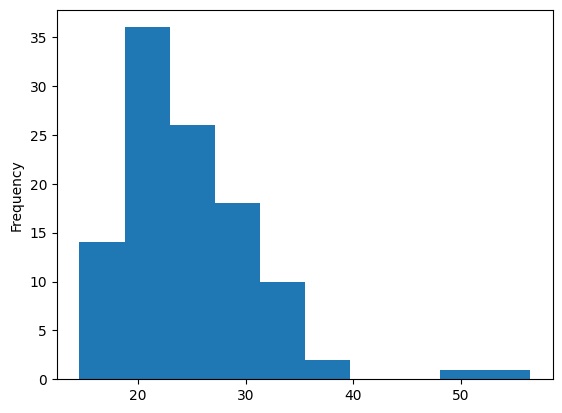

In [17]:
merged_df['true_score'].plot.hist()

<Axes: ylabel='Frequency'>

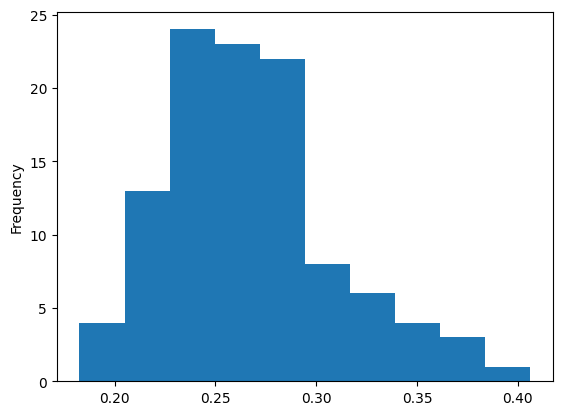

In [18]:
merged_df['jsd'].plot.hist()

In [ ]:
print("true: ", merged_df["true_score"].std() / merged_df["true_score"].mean())
print("Pure JSD: ", merged_df["jsd"].std() / merged_df["jsd"].mean())

# I was a little surprised at this result- I don't know why variance is higher for our "true score" than for JSD

true:  0.26111191805492046
Pure JSD:  0.16074222022425427


In [20]:
df.head()

,Unnamed: 0,question,country,selections,options,llm_reasoning,llm_distribution,num_selections,jsd
0,0,Now I'd like you to tell me your views on vari...,Albania,"[0.251, 0.102, 0.127, 0.102, 0.167, 0.066, 0.0...","['Competition is good', '2', '3', '4', '5', '6...",Albania is a country with a transitioning econ...,"[0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.1, 0.0...",13,0.235625
1,1,Now I'd like you to tell me your views on vari...,Albania,"[0.16399999999999998, 0.057, 0.081999999999999...",['The government should take more responsibili...,Albania is a country with a history of a stron...,"[0.25, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0....",13,0.202583
2,2,In which of the following things do you believ...,Albania,"[0.456, 0.46399999999999997, 0.066, 0.012, 0.001]","['Yes', 'No', ""Don't know"", 'No answer', 'Othe...",Albania is a country with a diverse religious ...,"[0.4, 0.35, 0.15, 0.1, 0.0]",5,0.219585
3,3,I ‘d like to ask you how much you trust people...,Albania,"[0.066, 0.405, 0.312, 0.16, 0.045, 0.01, 0.002]","['Trust completely', 'Trust somewhat', 'Do not...",Albania is a country with a diverse religious ...,"[0.15, 0.5, 0.2, 0.1, 0.03, 0.02, 0.0]",7,0.181561
4,4,I'm going to read out a list of various change...,Albania,"[0.309, 0.189, 0.466, 0.028999999999999998, 0....","['Good thing', ""Don't mind"", 'Bad thing', ""Don...","Albania is a country with a strong work ethic,...","[0.25, 0.15, 0.5, 0.05, 0.03, 0.02]",6,0.142271


In [21]:
df['jsd_category'] = df['jsd'].apply(lambda x: 'low' if x < 0.15 else 'high')

fig = px.histogram(
    df,
    x='jsd',
    color='jsd_category',
    nbins=100,
    color_discrete_map={'low': '#006400', 'high': '#8B0000'}
)
fig.show()